# Discrete Events and Coffee Shops

- toc: true
- branch: master
- badges: false
- comments: true
- categories: [python, simulation]
- image: images/order_coffee.png
- hide: false
- search_exclude: false
- annotations: true

> We use discrete-event simulation to model a coffee shop.

<img class="docimage" src="../images/cafe_greco_passini.jpg" alt="A painting of an old cafe in Rome." style="max-width: 90%"/>

*Ludwig Passini - Cafe Greco*. Depicted is one of the oldest cafes in Rome, first opened in 1760.

## Discrete-event simulation

In a discrete-event simulation we model a system as a sequence of events that occur at discrete times. For example, in a grocery queue, the events might be: (1) customer lines up at the queue, (2) customer reaches cashier, and (3) completes the transaction. The entire system is modeled via events and no state change occurs between events.

Discrete event simulations have a large number of applications in logistics, operations and many others. They can be a useful addition in a data scientist's toolbelt.

## Simpy

Simpy is a Python package for discrete-event simulation. The package provides three main constructs: events, processes and resources. We will discuss resources in the Coffee Shop simulation, below we illustrate the first two constructs.

Processes model components of a system by emitting events. Processes are defined by a Python generator. A generator allows for the temporary suspension of a process, and it makes it very convenient to model various components. Here is an example:

In [2]:
import simpy

def worker(env, worker_id, time_to_complete):
    """A worker finishes a part every time_to_complete minutes"""
    i = 1
    while True:
        yield env.timeout(time_to_complete)
        print(f"worker {worker_id} finished {i} parts at {env.now}")
        i += 1
        
env = simpy.Environment()
env.process(worker(env, worker_id=1, time_to_complete=20))
env.process(worker(env, worker_id=2, time_to_complete=30))
env.run(until=100)

worker 1 finished 1 parts at 20
worker 2 finished 1 parts at 30
worker 1 finished 2 parts at 40
worker 2 finished 2 parts at 60
worker 1 finished 3 parts at 60
worker 1 finished 4 parts at 80
worker 2 finished 3 parts at 90


Above we create two worker processes. A worker simply takes `time_to_complete` minutes to complete a part. The "waiting" part is determined by a simpy Timeout event, which allows for simulation time to pass. When the timeout is complete (the event has been processed), the worker process is resumed and the entire procedure repeats.

Note that the two workers are running concurrently. The simpy environment keeps track of events in an event queue and will resume the appropriate process once an event has been processed. Now, onto the coffee shop simulation! 

## Coffee Shop 

<img class="docimage" src="../images/order_coffee.png" alt="Diagram showing coffee order." style="max-width: 90%"/>

In the coffee shop simulation, we model the ordering process. Each customer orders `n_cups` of coffee. For simplicity, we model the number of cups only, and not the type of coffee. There will be no caramel macchiato with chocolate drizzle available! Most customers buy one or two cups of coffee, occasionally up to four.

We also sample the times between customer arrivals (`interarrival`) from an exponential distribution. This is a common choice as it assumes customers are arriving independently of each other. Below is an example using a mean interarrival time of 2 minutes with 20 customers.

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

def pick_n_cups():
    return random.choices(range(1, 5), [0.6, 0.25, 0.05, 0.05])[0]

def interarrival(mean):
    assert mean > 0
    return random.expovariate(1 / mean)

mean_delta = 2  # minutes
n_customers = 20
arrival_deltas = [interarrival(mean_delta) for _ in range(n_customers)]
n_cups = [pick_n_cups() for _ in range(n_customers)]
arrival_times = np.cumsum(arrival_deltas)

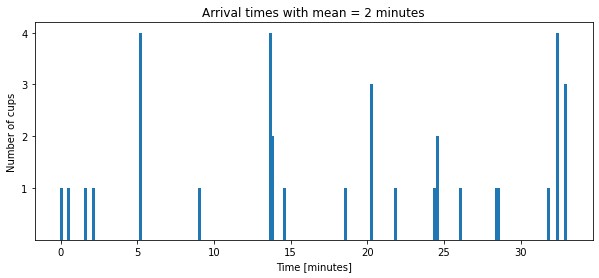

In [4]:
#collapse
plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.bar(arrival_times, n_cups, width=0.2)
ax.set_yticks(range(1, 5))
ax.set_xlabel("Time [minutes]")
ax.set_ylabel("Number of cups")
ax.set_title(f"Arrival times with mean = {mean_delta} minutes");

We see that it takes about 40 minutes for 20 customers to arrive, as we would expect with a mean of 2 minutes. 

## Barristas and resources 

Let's start with a simplified model where we only have barristas, so a customer can directly request coffee from them without going through checkout. We use a simpy `Resource` to model barristas. A resource is typically shared between multiple processes, and they queue to use it. A resource has a capacity - in this case this determines the number of barristas. Other types of resources are also available: for example, containers can be used to model a continuous quantity.

In [25]:
from collections import namedtuple

Order = namedtuple("Order", ["id", "n_cups"])

def time_per_cup(avg_time=2):
    return random.normalvariate(avg_time, 0.5)

def prepare_coffee(env, order, barrista):
    print(f"begin order {order.id}", round(env.now, 3))
    with barrista.request() as req:
        yield req  # wait until a barrista is available
        prepare_time = order.n_cups * time_per_cup()
        yield env.timeout(prepare_time)  # preparing coffee
        
    print(f"order {order.id} ready!", round(env.now, 3))
    
def generate_customers(env, barrista, mean_delta=2):
    i = 0
    while True:
        order = Order(i, pick_n_cups())
        yield env.timeout(interarrival(mean_delta))
        env.process(prepare_coffee(env, order, barrista))
        i += 1

Each order is a namedtuple, which contains the order `id` (so we can track it through the simulation), as well as the `n_cups` which impacts the time it takes to prepare the order. We assume the order prep time is linear with `n_cups`.

The simulation currently consists of two processes. The main process is `prepare_coffee` which models how a coffee is prepared. We first request the `barrista` resource, which means we wait until a barrista is available, and then prepare the order based on `n_cups`. When we exist the `barrista.request()` context, the barrista is released by the current process, and becomes available to fulfull other orders. 

The `generate_customers` resource simply generates orders based a `mean_delta` value using the `interarrival` distribution we saw before.

In [27]:
env = simpy.Environment()
barrista = simpy.Resource(env, capacity=1)
env.process(generate_customers(env, barrista))
env.run(until=20)

begin order 0 1.201
begin order 1 1.233
order 0 ready! 2.763
begin order 2 2.863
begin order 3 3.397
order 1 ready! 4.688
begin order 4 5.159
begin order 5 5.245
begin order 6 7.831
order 2 ready! 8.99
begin order 7 11.47
begin order 8 11.786
order 3 ready! 13.342
begin order 9 15.774
order 4 ready! 17.371
begin order 10 17.493


In [22]:
class CoffeeSimSimple:
    def __init__(self, env, n_barristas, to_log=False):
        self.env = env
        self.barrista = simpy.Resource(env, capacity=n_barristas)
        self.barrista_ledger = {}  # for saving data
        self.to_log = to_log
        
    def prepare_coffee(self, order):
        begin_time = self.env.now
        self.barrista_ledger[begin_time] = 1
        if self.to_log: print(f"begin order {order.id}", round(self.env.now, 3))
        
        with self.barrista.request() as req:
            yield req  # wait until a barrista is available
            prepare_time = order.n_cups * time_per_cup()
            yield self.env.timeout(prepare_time)
        
        ready_time = self.env.now
        self.barrista_ledger[ready_time] = -1
        if self.to_log: print(f"order {order.id} ready!", round(ready_time, 3))

    def generate_customers(self, mean_delta=2):
        i = 0
        while True:
            order = Order(i, pick_n_cups())
            yield self.env.timeout(interarrival(mean_delta))
            self.env.process(self.prepare_coffee(order))
            i += 1
     
    def run(self, mean_delta, until):
        self.env.process(self.generate_customers(mean_delta))
        self.env.run(until=until)

In [24]:
coffee_sim = CoffeeSimSimple(simpy.Environment(), n_barristas=2, to_log=True)
coffee_sim.run(2, 20)

begin order 0 1.459
begin order 1 2.034
order 0 ready! 3.532
begin order 2 4.098
order 1 ready! 4.133
order 2 ready! 5.961
begin order 3 8.894
begin order 4 10.197
order 3 ready! 10.336
begin order 5 10.579
begin order 6 11.866
order 4 ready! 11.96
order 5 ready! 12.714
begin order 7 13.442
order 6 ready! 14.122
order 7 ready! 15.253
begin order 8 15.494
order 8 ready! 17.988
